#### 분류평가 
- 정확도만으로 분균형한 레이블 데이터 세트에서 평가지표로 사용하기에는 부적합
- 정확도가 가지는 분류 평가 지표로의 한계점을 극복하기 위해 여러가지 분류 지표와 함께 적용해야 함

#### Confusion Matrix(혼동행렬, 오차행렬) >> 빅분기 빈출주제
- 이진분류에서 성능지표로 잘 활용되는 오차행렬은 학습된 분류모델이 예측을 수행하면 얼마나 혼동될 수 있는지도 함께 보여주는 지표
- 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 보여줌

#### 평가 지표
- TP,FP,FN,TN(책 152- 153page 참조)는 예측클래스와 실제 클래스의 Positive 결정 값과 Negative 결정 값의 결함에 따라 결정
- 앞문자 True/False는 예측값과 실제값이 같은가/틀린가를 의미하고 뒤 문자 N/P는 예측 결과값이 부정/긍정을 의미
- 정확도 = (TP + TN) / (TP + TN + FP + FN)
- 정밀도 = TP / (TP + FP) : P로 예측한 것 중에서 실제로 P인 것을 나타냄
- 재현율 = TP / (TP + FN) : 실제 P인 것 중에서 예측도 P
- $F1 score = 2*\frac{정밀도*재현율}{정밀도+재현율}$ : 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼때 높아지도록 표기
- 정밀도와 재현율은 Positive 데이터 세트의 예측성능에 좀더 초점을 맞춘 평가 지표
- 재현율이 중요한 지표인 경우: 양성데이터를 음성으로 잘못 판단하면 업무상 큰 영향이 발생하는 경우(암진단, 보험사기)
- 정밀도가 더 중요한 지표인 사례 : 스팸 메일 여부를 판단하는 경우로 스팸 메일이 아닌데 스팸 메일로 분류해서 업무 차질이 발생하는 경우

#### 정밀도 및 재현율 활용 시 유의사항
- 정밀도와 재현율 성능 수치는 어느 한쪽만 참조하면 극단적인 수치 조작이 가능
- 정밀도 100%가 되는 방법 : 확실한  기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측 TP/(TP+FP) = 1/(1+0) = 1
- 재현율이 100%가 되는 방법 : 실제 양성 1000명중 30명 TP/(TP + FN) = 30/(30 + 0) = 1
- 분류가 정밀도, 재현율 중 하나에 상대적인 중요도를 부여할 수 있지만, 하나만 강조해서는 안됨
- 암 예측 모델에서 재현율을 높힌다고 주로 양성만 판정한다면, 환자의 불만과 불평이 커지게 된다.

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test,pred):
    confusion = confusion_matrix( y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    print(f'오차행렬:\n {confusion}')
    print(f'정확도:{round(accuracy,4)},정밀도:{round(precision,4)},재현율:{round(recall,4)}')


In [3]:
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler



def fillnas(df):
    def callname(x):
        m = re.compile('[A-Za-z]+[.]')
        p = re.findall(m,x)
        return p[0]
    
    df['Callname']=df.Name.apply(lambda x:callname(x))
    
    df1 = df.loc[df.Age.isnull()]
    age_nulllist = list(set(df1.Callname.values.tolist()))
    
    df2 = df.loc[df.Age.notnull()]
    pivot = pd.pivot_table(df2, index = 'Callname', values = 'Age',aggfunc = 'mean')
    
    for age in age_nulllist:
        df.loc[(df.Age.isnull())&(df.Callname == age),['Age']]=(pivot.loc[age][0])
        
    df['Embarked'].fillna(method = 'ffill',inplace=True)
    
    df3 = df.loc[df.Cabin.notnull()]

    df3['Cabins'] = df3['Cabin'].str[:1]
    df4 = df.loc[df.Cabin.isnull()]
    
    for i in range(1,4):
        df33 = df3.loc[df3.Pclass == i]
        cabin_fill_list=list(set(df33.Cabins.values.tolist()))
        df44 = df4.loc[df4.Pclass == i]
        fill_index = list(df44.index)
        for index in fill_index:
            df.loc[index,'Cabin'] = np.random.choice(cabin_fill_list)
            
    return df

# 불필요 항목 제거
def drop_feat(df):
    df.drop(['PassengerId','Name','Ticket','Callname'],axis=1,inplace = True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    scaler = MinMaxScaler()
    scaler.fit(df[['Fare']])
    fare_scaled = scaler.transform(df[['Fare']])
    df['Fare'] = fare_scaled
    
    return df

def transform_features(df):
    df = fillnas(df)
    df = drop_feat(df)
    df = format_features(df)
    return df

In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
t_df = pd.read_csv('./dataset/train.csv')
y_t_df = t_df['Survived']
X_t_df = t_df.drop('Survived',axis=1)
X_t_df = transform_features(X_t_df)
X_t_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,0.014151,5,2
1,1,0,38.0,1,0,0.139136,2,0
2,3,0,26.0,0,0,0.015469,6,2
3,1,0,35.0,1,0,0.103644,2,2
4,3,1,35.0,0,0,0.015713,6,2


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


X_train, X_test, y_train, y_test = train_test_split(X_t_df,y_t_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

# 오차행렬 109 : 죽었다고 예측했는데 죽는경우 , 9 : 살아있다고 예측했는데 죽는경우, 15 : 죽었다고 예측했는데 살아있는경우
# 45 : 살아있다고 예측햇는데 살아있는 경우

오차행렬:
 [[103  15]
 [ 14  47]]
정확도:0.838,정밀도:0.7581,재현율:0.7705


# Q.오차행렬을 보고 수작업으로 계산하여 아래를 구하세요
TN = 109, 
accuracy : ()
precision:
recall:
f1 score:

In [6]:
# 다시해서 연습해보기
confusion = confusion_matrix(y_test, pred)
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
TP = confusion[1,1]
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print('정확도: ',round(accuracy,4))
print('정밀도: ',round(precision,4))
print('재현율: ',round(recall,4))
print('F1 Score: ',round(2 * ((precision * recall) / (precision + recall)),4))


정확도:  0.838
정밀도:  0.7581
재현율:  0.7705
F1 Score:  0.7642


In [7]:
TN = 109; FP=9; FN =15; TP=46;
accuracy = round((TP+TN)/(TP+TN+FP+FN),4)
precision = round((TP)/(TP+FP),4)
recall = round((TP)/(TP+FN),4)
print('accuracy:',accuracy)
print('precision:', precision)
print('recall:',recall)
print('f1 score:',round(2 *(precision*recall)/(precision+recall),4))

accuracy: 0.8659
precision: 0.8364
recall: 0.7541
f1 score: 0.7931


위에 있는 TP,TN,FP,FN은 P153에 있는 표를 기준으로 하였으며, 표의 내용이 달라지면 위에 있는 수작업한 내용들이 달라진다


In [8]:
# Precision/Recall Trade-off관계에 있다는 걸 증명!!
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
pred_proba_result = np.concatenate([pred_proba,pred.reshape(-1,1)],axis=1)
pred_proba_result[:3]

array([[0.51280586, 0.48719414, 0.        ],
       [0.89344372, 0.10655628, 0.        ],
       [0.87230655, 0.12769345, 0.        ]])

In [9]:
from sklearn.preprocessing import Binarizer

In [10]:
X = [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]

binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [11]:
#threshold는 임의적으로 조작을 해야되는 경우에 사용한다
custom_threshold =0.5
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
pred_proba_1

array([[0.48719414],
       [0.10655628],
       [0.12769345],
       [0.14649695],
       [0.17046846],
       [0.11421749],
       [0.10950708],
       [0.80566895],
       [0.25841796],
       [0.64281162],
       [0.11826234],
       [0.13426636],
       [0.10444511],
       [0.1095401 ],
       [0.53215334],
       [0.15224499],
       [0.08912385],
       [0.31708343],
       [0.24506587],
       [0.8444753 ],
       [0.2936228 ],
       [0.3598718 ],
       [0.12928091],
       [0.1850399 ],
       [0.08947748],
       [0.26079125],
       [0.16695275],
       [0.06493433],
       [0.28465982],
       [0.2735363 ],
       [0.92954706],
       [0.78708173],
       [0.1240464 ],
       [0.84123091],
       [0.37776117],
       [0.26079125],
       [0.07643303],
       [0.56537687],
       [0.04910885],
       [0.10013359],
       [0.38727182],
       [0.07246057],
       [0.78927501],
       [0.74391645],
       [0.66827331],
       [0.69298121],
       [0.91001295],
       [0.314

In [12]:
custom_threshold =0.5
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)
custom_predict
get_clf_eval(y_test,custom_predict)

오차행렬:
 [[103  15]
 [ 14  47]]
정확도:0.838,정밀도:0.7581,재현율:0.7705


In [13]:
# 분류 결정 임계값을 0.5에서 0.4로 조정한다? (정밀도는 떨이지고 재현율은 상승한다[즉 trade-off의 관계가 나타난다.])

In [14]:
custom_threshold = 0.4

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)
custom_predict
get_clf_eval(y_test,custom_predict)

오차행렬:
 [[97 21]
 [10 51]]
정확도:0.8268,정밀도:0.7083,재현율:0.8361


In [15]:
# Q. 임계값을 [0.4, 0.45, 0.5, 0.55, 0.6] 으로 변경 시 각 평가지표의 변화를 출력하세요.

In [16]:
custom_threshold_list = [0.4, 0.45, 0.50, 0.55, 0.60]

for i in custom_threshold_list:
    binarizer = Binarizer(threshold=i).fit(pred_proba_1)
    custom_predict = binarizer.transform(pred_proba_1)
    print('임곗값:', i)
    
    result = get_clf_eval (y_test, custom_predict)
    print()

임곗값: 0.4
오차행렬:
 [[97 21]
 [10 51]]
정확도:0.8268,정밀도:0.7083,재현율:0.8361

임곗값: 0.45
오차행렬:
 [[102  16]
 [ 13  48]]
정확도:0.838,정밀도:0.75,재현율:0.7869

임곗값: 0.5
오차행렬:
 [[103  15]
 [ 14  47]]
정확도:0.838,정밀도:0.7581,재현율:0.7705

임곗값: 0.55
오차행렬:
 [[110   8]
 [ 15  46]]
정확도:0.8715,정밀도:0.8519,재현율:0.7541

임곗값: 0.6
오차행렬:
 [[112   6]
 [ 16  45]]
정확도:0.8771,정밀도:0.8824,재현율:0.7377



In [17]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
    custom_predict = binarizer.transform(pred_proba_1)
    print(f'임계값:',custom_threshold)
    
    result = get_clf_eval(y_test,custom_predict)
    print()
   
        


임계값: 0.4
오차행렬:
 [[97 21]
 [10 51]]
정확도:0.8268,정밀도:0.7083,재현율:0.8361

임계값: 0.45
오차행렬:
 [[102  16]
 [ 13  48]]
정확도:0.838,정밀도:0.75,재현율:0.7869

임계값: 0.5
오차행렬:
 [[103  15]
 [ 14  47]]
정확도:0.838,정밀도:0.7581,재현율:0.7705

임계값: 0.55
오차행렬:
 [[110   8]
 [ 15  46]]
정확도:0.8715,정밀도:0.8519,재현율:0.7541

임계값: 0.6
오차행렬:
 [[112   6]
 [ 16  45]]
정확도:0.8771,정밀도:0.8824,재현율:0.7377



In [18]:
# [과제] 임곗값을 0~1로 변경시킬때 precision과 recall의 변화 추세를 시각화하여 출력하세요

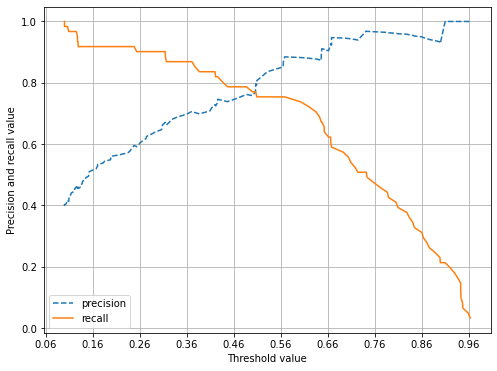

In [19]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test,pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

In [20]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test,pred)
print(f'f1 score: {round(f1,4)}')

f1 score: 0.7642


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_eval(y_test,pred):
    confusion = confusion_matrix( y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    print(f'오차행렬:\n {confusion}')
    print(f'정확도:{round(accuracy,4)},정밀도:{round(precision,4)},재현율:{round(recall,4)},f1_score:{round(f1,4)}')


In [22]:
get_clf_eval(y_test,pred)

오차행렬:
 [[103  15]
 [ 14  47]]
정확도:0.838,정밀도:0.7581,재현율:0.7705,f1_score:0.7642


#### ROC Curve와 AUC
- 수신자 판단 곡선이라고 하며 ML의 이진 분류 모델의 예측 성능을 판단하는 중요한 평가 지표
- FPR (FP의 비율)이 변할 때 TPR이 어떻게 변하는지를 나타내는 곡선으로 FPR = 1 - TNR(특이성),TPR은 재현율(민감도)를 나타냄 >> negative전체가 되기때문
- TNR = TN/(TN + FP)이며 FPR은 FP/(TN + FP) 
- ROC 곡선은 FPR을 0부터 1까지 변경하면서 FPR을 구하고 이 FPR 값의 변화에 따른 TPR의 변화 값을 구함
- FPR을 0에서 1까지 변경하는 것은 P 예측값을 결정하는 기준인 분류 결정 임곗값을 변경하면 된다.
- FPR을 0으로 만들려면, 임곗값을 1로 지정하고 반대로 FPR을 1로 만들려면 임곗값을 0으로  지정


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
    
def roc_curve_plot(y_test, pred_proba_c1):    
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba_c1)

        #len(thresholds)
    plt.plot(fprs, tprs, label = 'ROC')
    plt.plot([0,1],[0,1],'k--',label ='Random')

    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()


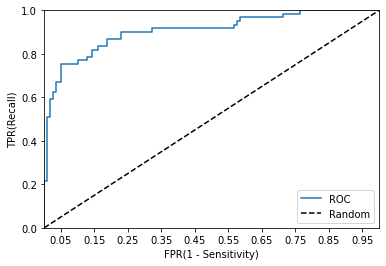

In [24]:
roc_curve_plot(y_test,pred_proba_c1)

In [25]:
from sklearn.metrics import roc_auc_score
pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test,pred_proba)
round(roc_score,4)

0.9069

In [26]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix( y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    print(f'오차행렬:\n {confusion}')
    print(f'정확도:{round(accuracy,4)},정밀도:{round(precision,4)},재현율:{round(recall,4)},f1_score:{round(f1,4)},auc: {round(roc_auc,4)}')

In [27]:
get_clf_eval(y_test,pred,pred_proba)

오차행렬:
 [[103  15]
 [ 14  47]]
정확도:0.838,정밀도:0.7581,재현율:0.7705,f1_score:0.7642,auc: 0.9069


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

titanic_df = pd.read_csv('./dataset/train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
from sklearn.preprocessing import LabelEncoder

def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df


def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [31]:

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier
dt_clf.fit(X_train , y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 
rf_clf.fit(X_train , y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 
lr_clf.fit(X_train , y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도: 0.7542
RandomForestClassifier 정확도:0.8659
LogisticRegression 정확도: 0.8380


[과제] train.csv 파일을 불러와서 분류모델링 평가를 아래와 같이 수행하세요.
- dt 모델을 적용하고 GridSearchCV를 사용, 교차검증과 성능 개선을 위한 하이퍼파라미터 튜닝
- accuracy에 추가하여 confusion matrix, accuracy, precision, recall, roc auc score 평가


In [32]:
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import roc_auc_score

def get_category(age):
    cat = ''
    if age < 10:
        cat = 'a'
    elif 10 <= age < 20:
        cat = 'b'
    elif 20 <= age < 30:
        cat = 'c'
    elif 30 <= age < 40:
        cat = 'd'
    elif 40 <= age < 50:
        cat = 'e'
    elif 10 <= age < 60:
        cat = 'f'
    else:
        cat = 6
    return cat


df = pd.read_csv('./dataset/train.csv')
df['Title'] = df['Name'].apply(lambda x: re.search(' ([A-Za-z]+)\.', x).group(0).strip())
df['Family'] = df['SibSp']+df['Parch']
df.drop(['SibSp', 'Parch','Ticket', 'Name', 'PassengerId', 'Cabin'], axis=1,inplace=True)
df['Age'] = df.groupby(['Pclass', 'Sex', 'Title'])['Age'].apply(lambda x: x.fillna(x.mean()))
df['Embarked'].fillna('S', inplace=True)
df['Age_cat'] = df['Age'].apply(lambda x: get_category(x))
cnt, bins = np.histogram(df.Fare, bins=5)
df['Fare_bins'] = pd.cut(x=df.Fare, bins=bins, labels=[
                         0, 1, 2, 3, 4], include_lowest=True)
df = df.drop(['Age', 'Title', 'Fare'], axis=1)

df1 = df.copy()
df1 = df.drop(['Survived'], axis=1)
df1['Pclass'] = df1['Pclass'].astype('str')
df1 = pd.get_dummies(df1[['Pclass', 'Sex', 'Embarked', 'Age_cat', 'Fare_bins']])

X_train, X_test, y_train, y_test = train_test_split(
    df1, df.Survived, test_size=0.2)

dtree = RandomForestClassifier(random_state=71)
parameters = {'max_depth': [3, 4, 5, 6],
              'min_samples_split': [2, 3, 4, 5]}

grid_dtree = GridSearchCV(dtree, param_grid=parameters, cv=5, refit=True)
grid_dtree.fit(X_train, y_train)
scores_df = pd.DataFrame(grid_dtree.cv_results_)
# display(scores_df[['params', 'mean_test_score', 'rank_test_score']])
print('GridSearchCV 최적 파라미터 :', grid_dtree.best_params_)
print(f'GridSearchCV 최고 정확도 : {grid_dtree.best_score_.round(3)}')
estimator = grid_dtree.best_estimator_
pred = estimator.predict(X_test)
print(f'데스트 정확도 : {accuracy_score(y_test, pred)}')


GridSearchCV 최적 파라미터 : {'max_depth': 6, 'min_samples_split': 4}
GridSearchCV 최고 정확도 : 0.826
데스트 정확도 : 0.8100558659217877


In [33]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix( y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    print(f'오차행렬:\n {confusion}')
    print(f'정확도:{round(accuracy,4)},정밀도:{round(precision,4)},재현율:{round(recall,4)},f1_score:{round(f1,4)},auc: {round(roc_auc,4)}')

In [34]:
get_clf_eval(y_test,pred,pred_proba)

오차행렬:
 [[104   4]
 [ 30  41]]
정확도:0.8101,정밀도:0.9111,재현율:0.5775,f1_score:0.7069,auc: 0.5284


In [35]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],
             'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf , param_grid=parameters , scoring='accuracy' , cv=5)
grid_dclf.fit(X_train , y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
pred = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.8203
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.7989


In [36]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion = confusion_matrix( y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    print(f'오차행렬:\n {confusion}')
    print(f'정확도:{round(accuracy,4)},정밀도:{round(precision,4)},재현율:{round(recall,4)},f1_score:{round(f1,4)},auc: {round(roc_auc,4)}')

In [37]:
get_clf_eval(y_test,pred,pred_proba)

오차행렬:
 [[103   5]
 [ 31  40]]
정확도:0.7989,정밀도:0.8889,재현율:0.5634,f1_score:0.6897,auc: 0.5284


[과제] diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.

- SkinThickness 와 Insulin의 0 값은 상당히 많기 때문에 일괄 삭제가 어려우며 평균값으로 대체
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
- 산출된 임계값을 적용한 평가<BR>
※ 피처 정보
 - 'Pregnancies'(임신 횟수), 
 - 'Glucose'(포도당 부하 검사 수치), 
 - 'BloodPressure'(혈압), 
 - 'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값, 
 - 'Insulin'(혈청 인슈린), 
 - 'BMI'(체질량 지수), 
 - 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 
 - 'Age', 
 - 'Outcome'


 - 데이터 세트는 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터임.
 - 고립된 지역에서 인디언 고유의 혈통이 지속돼 왔지만 20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자 발생


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


In [39]:
diabetes_data = pd.read_csv('./dataset/diabetes.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [40]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [41]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 156, stratify=y)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test,pred,pred_proba)

오차행렬:
 [[88 12]
 [23 31]]
정확도:0.7727,정밀도:0.7209,재현율:0.5741,f1_score:0.6392,auc: 0.7919


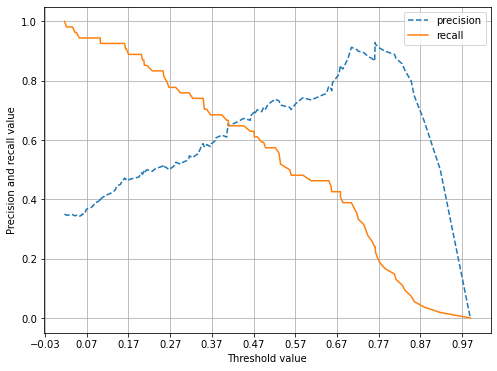

In [42]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [43]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [44]:
#min값이 0으로 되어 있는 것에 대해 0값의 건수 및 전체 데이터 건수대비 몇퍼센트인가?

In [45]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복 하면서 데이터 값이 0 인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [46]:
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0,mean_zero_features)

In [47]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler( )
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차행렬:
 [[90 10]
 [21 33]]
정확도:0.7987,정밀도:0.7674,재현율:0.6111,f1_score:0.6804,auc: 0.8433


In [48]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)

In [49]:
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.3
오차행렬:
 [[67 33]
 [11 43]]
정확도:0.7143,정밀도:0.5658,재현율:0.7963,f1_score:0.6615,auc: 0.8433
임곗값: 0.33
오차행렬:
 [[72 28]
 [12 42]]
정확도:0.7403,정밀도:0.6,재현율:0.7778,f1_score:0.6774,auc: 0.8433
임곗값: 0.36
오차행렬:
 [[76 24]
 [15 39]]
정확도:0.7468,정밀도:0.619,재현율:0.7222,f1_score:0.6667,auc: 0.8433
임곗값: 0.39
오차행렬:
 [[78 22]
 [16 38]]
정확도:0.7532,정밀도:0.6333,재현율:0.7037,f1_score:0.6667,auc: 0.8433
임곗값: 0.42
오차행렬:
 [[84 16]
 [18 36]]
정확도:0.7792,정밀도:0.6923,재현율:0.6667,f1_score:0.6792,auc: 0.8433
임곗값: 0.45
오차행렬:
 [[85 15]
 [18 36]]
정확도:0.7857,정밀도:0.7059,재현율:0.6667,f1_score:0.6857,auc: 0.8433
임곗값: 0.48
오차행렬:
 [[88 12]
 [19 35]]
정확도:0.7987,정밀도:0.7447,재현율:0.6481,f1_score:0.6931,auc: 0.8433
임곗값: 0.5
오차행렬:
 [[90 10]
 [21 33]]
정확도:0.7987,정밀도:0.7674,재현율:0.6111,f1_score:0.6804,auc: 0.8433


[과제]

아래는 백화점 고객의 1년 간 구매 데이터이다.

(가) 제공 데이터 목록

① y_train.csv : 고객의 성별 데이터 (학습용), CSV 형식의 파일

② X_train.csv, X_test.csv : 고객의 상품구매 속성 (학습용 및 평가용), CSV 형식의 파일

(나) 데이터 형식 및 내용

① y_train.csv (3,500명 데이터)

② X_train.csv (3,500명 데이터), X_test.csv (2,482명 데이터)

 고객 3,500명에 대한 학습용 데이터(y_train.csv, X_train.csv)를 이용하여 성별예측 모형을 만든 후, 이를 평가용 데이터(X_test.csv)에 적용하여 얻은 2,482명 고객의 성별 예측값(남자일 확률)을 다음과 같은 형식의 CSV 파일로 생성하시오.(제출한 모델의 성능은 ROC-AUC 평가지표에 따라 채점)

<제출형식>
custid,gender
  
  3500,0.267
  
  3501,0.578
  
  3502,0.885
  ․ ․ ․


성능이 우수한 예측모형을 구축하기 위해서는 적절한 데이터 전처리, Feature Engineering, 분류 알고리즘 사용, 초매개변수 최적화, 모형 앙상블 등이 수반되어야 한다

In [50]:
import pandas as pd
import numpy as np


In [51]:
X = pd.read_csv('./dataset/X_train.csv',encoding='cp949')
X.head()

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17
1,1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1
2,2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1
3,3,16077620,4935000,NaN,기타,광주점,18,2.444444,0.318182,16
4,4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85


In [52]:
Y = pd.read_csv('./dataset/Y_train.csv',encoding='cp949')
Y.head()

,cust_id,gender
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0


In [53]:
test = pd.read_csv('./dataset/X_test.csv',encoding='cp949')
test.head()

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,3500,70900400,22000000,4050000.0,골프,부산본점,13,1.461538,0.789474,26
1,3501,310533100,38558000,48034700.0,농산물,잠실점,90,2.433333,0.369863,3
2,3502,305264140,14825000,30521000.0,가공식품,본 점,101,14.623762,0.083277,3
3,3503,7594080,5225000,NaN,주방용품,부산본점,5,2.000000,0.000000,47
4,3504,1795790,1411200,NaN,수산품,청량리점,3,2.666667,0.125000,8


In [54]:
X.dtypes

cust_id      int64
총구매액         int64
최대구매액        int64
환불금액       float64
주구매상품       object
주구매지점       object
내점일수         int64
내점당구매건수    float64
주말방문비율     float64
구매주기         int64
dtype: object

In [55]:
Y.dtypes

cust_id    int64
gender     int64
dtype: object

In [56]:
test.dtypes

cust_id      int64
총구매액         int64
최대구매액        int64
환불금액       float64
주구매상품       object
주구매지점       object
내점일수         int64
내점당구매건수    float64
주말방문비율     float64
구매주기         int64
dtype: object

In [57]:
X.isnull().sum()

cust_id       0
총구매액          0
최대구매액         0
환불금액       2295
주구매상품         0
주구매지점         0
내점일수          0
내점당구매건수       0
주말방문비율        0
구매주기          0
dtype: int64

In [58]:
Y.isnull().sum()

cust_id    0
gender     0
dtype: int64

In [59]:
test.isnull().sum()

cust_id       0
총구매액          0
최대구매액         0
환불금액       1611
주구매상품         0
주구매지점         0
내점일수          0
내점당구매건수       0
주말방문비율        0
구매주기          0
dtype: int64

In [60]:
X = X.fillna(0)
test = test.fillna(0)

In [61]:
X = X.drop(['cust_id'], axis=1)
cust_id = test.pop('cust_id')

In [62]:
from sklearn.preprocessing import LabelEncoder
cols = ['주구매상품','주구매지점']
for col in cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    test[col] = le.fit_transform(test[col])
    
X.head()

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,68282840,11264000,6860000.0,5,0,19,3.894737,0.527027,17
1,2136000,2136000,300000.0,21,19,2,1.500000,0.000000,1
2,3197000,1639000,0.0,6,1,2,2.000000,0.000000,1
3,16077620,4935000,0.0,5,2,18,2.444444,0.318182,16
4,29050000,24000000,0.0,15,8,2,1.500000,0.000000,85


In [63]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=2022)
model.fit(X, Y['gender'])
print(model.score(X, Y['gender']))
predictions = model.predict_proba(test)

0.6874285714285714


In [64]:
predictions[:,1]

array([0.43567157, 0.19725558, 0.17732635, ..., 0.43703219, 0.36002886,
       0.54383742])

In [65]:
result= pd.DataFrame({'cust_id':cust_id,'gender':predictions[:,1]})
result.head()

,cust_id,gender
0,3500,0.435672
1,3501,0.197256
2,3502,0.177326
3,3503,0.420662
4,3504,0.485512


In [66]:
result.to_csv('test2_evaluation.csv', index=False)

In [67]:
P_result = pd.read_csv('./test2_evaluation.csv')
P_result

,cust_id,gender
0,3500,0.435672
1,3501,0.197256
2,3502,0.177326
3,3503,0.420662
4,3504,0.485512
...,...,...
2477,5977,0.474432
2478,5978,0.511048
2479,5979,0.437032
2480,5980,0.360029


In [68]:
#######

In [69]:
x = pd.read_csv('./dataset/X_train.csv',encoding='cp949')
x.head()

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17
1,1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1
2,2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1
3,3,16077620,4935000,NaN,기타,광주점,18,2.444444,0.318182,16
4,4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85


In [70]:
y = pd.read_csv('./dataset/Y_train.csv',encoding='cp949')
y.head()

,cust_id,gender
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0


In [71]:
validation = pd.read_csv('./dataset/X_test.csv',encoding='cp949')
validation

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,3500,70900400,22000000,4050000.0,골프,부산본점,13,1.461538,0.789474,26
1,3501,310533100,38558000,48034700.0,농산물,잠실점,90,2.433333,0.369863,3
2,3502,305264140,14825000,30521000.0,가공식품,본 점,101,14.623762,0.083277,3
3,3503,7594080,5225000,NaN,주방용품,부산본점,5,2.000000,0.000000,47
4,3504,1795790,1411200,NaN,수산품,청량리점,3,2.666667,0.125000,8
...,...,...,...,...,...,...,...,...,...,...
2477,5977,82581500,23976000,NaN,골프,부산본점,8,1.750000,0.642857,40
2478,5978,480000,480000,NaN,섬유잡화,광주점,1,1.000000,0.000000,0
2479,5979,260003790,25750000,NaN,남성 캐주얼,본 점,19,3.736842,0.915493,18
2480,5980,88991520,18120000,NaN,육류,본 점,5,3.600000,0.444444,60


In [72]:
x.dtypes

cust_id      int64
총구매액         int64
최대구매액        int64
환불금액       float64
주구매상품       object
주구매지점       object
내점일수         int64
내점당구매건수    float64
주말방문비율     float64
구매주기         int64
dtype: object

In [73]:
x.describe()

,cust_id,총구매액,최대구매액,환불금액,내점일수,내점당구매건수,주말방문비율,구매주기
count,3500.000000,3.500000e+03,3.500000e+03,1.205000e+03,3500.000000,3500.000000,3500.000000,3500.000000
mean,1749.500000,9.191925e+07,1.966424e+07,2.407822e+07,19.253714,2.834963,0.307246,20.958286
std,1010.507298,1.635065e+08,3.199235e+07,4.746453e+07,27.174942,1.912368,0.289752,24.748682
min,0.000000,-5.242152e+07,-2.992000e+06,5.600000e+03,1.000000,1.000000,0.000000,0.000000
25%,874.750000,4.747050e+06,2.875000e+06,2.259000e+06,2.000000,1.666667,0.027291,4.000000
50%,1749.500000,2.822270e+07,9.837000e+06,7.392000e+06,8.000000,2.333333,0.256410,13.000000
75%,2624.250000,1.065079e+08,2.296250e+07,2.412000e+07,25.000000,3.375000,0.448980,28.000000
max,3499.000000,2.323180e+09,7.066290e+08,5.637530e+08,285.000000,22.083333,1.000000,166.000000


In [74]:
x.isnull().sum()

cust_id       0
총구매액          0
최대구매액         0
환불금액       2295
주구매상품         0
주구매지점         0
내점일수          0
내점당구매건수       0
주말방문비율        0
구매주기          0
dtype: int64

In [75]:
x = x.fillna(0)
x.isnull().sum()

cust_id    0
총구매액       0
최대구매액      0
환불금액       0
주구매상품      0
주구매지점      0
내점일수       0
내점당구매건수    0
주말방문비율     0
구매주기       0
dtype: int64

In [76]:
validation = validation.fillna(0)
validation.isnull().sum()

cust_id    0
총구매액       0
최대구매액      0
환불금액       0
주구매상품      0
주구매지점      0
내점일수       0
내점당구매건수    0
주말방문비율     0
구매주기       0
dtype: int64

In [77]:
x_mainobj = x['주구매상품'].unique()
x_mainpla = x['주구매지점'].unique()

print(x_mainobj)
print(len(x_mainobj))
print(x_mainpla)
print(len(x_mainpla))

['기타' '스포츠' '남성 캐주얼' '보석' '디자이너' '시티웨어' '명품' '농산물' '화장품' '골프' '구두' '가공식품'
 '수산품' '아동' '차/커피' '캐주얼' '섬유잡화' '육류' '축산가공' '젓갈/반찬' '액세서리' '피혁잡화' '일용잡화'
 '주방가전' '주방용품' '건강식품' '가구' '주류' '모피/피혁' '남성 트랜디' '셔츠' '남성정장' '생활잡화'
 '트래디셔널' '란제리/내의' '커리어' '침구/수예' '대형가전' '통신/컴퓨터' '식기' '소형가전' '악기']
42
['강남점' '잠실점' '관악점' '광주점' '본  점' '일산점' '대전점' '부산본점' '분당점' '영등포점' '미아점'
 '청량리점' '안양점' '부평점' '동래점' '포항점' '노원점' '창원점' '센텀시티점' '인천점' '대구점' '전주점'
 '울산점' '상인점']
24


In [78]:
print(set(x['주구매상품'].unique()) - set(validation['주구매상품'].unique()))
print(set(x['주구매지점'].unique()) - set(validation['주구매지점'].unique()))

{'소형가전'}
set()


In [79]:
print(set(validation['주구매상품'].unique()) - set(x['주구매상품'].unique())) 
print(set(validation['주구매지점'].unique()) - set(x['주구매지점'].unique()))


set()
set()


In [80]:
x[x['주구매상품'] == '소형가전']

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
1521,1521,178000,178000,0.0,소형가전,본 점,1,1.0,1.0,0
2035,2035,260000,260000,0.0,소형가전,잠실점,1,1.0,0.0,0


In [81]:
x1 = x[x['주구매상품'] != '소형가전'].reset_index(drop = True)
x1

,cust_id,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17
1,1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1
2,2,3197000,1639000,0.0,남성 캐주얼,관악점,2,2.000000,0.000000,1
3,3,16077620,4935000,0.0,기타,광주점,18,2.444444,0.318182,16
4,4,29050000,24000000,0.0,보석,본 점,2,1.500000,0.000000,85
...,...,...,...,...,...,...,...,...,...,...
3493,3495,3175200,3042900,0.0,골프,본 점,1,2.000000,1.000000,0
3494,3496,29628600,7200000,6049600.0,시티웨어,부산본점,8,1.625000,0.461538,40
3495,3497,75000,75000,0.0,주방용품,창원점,1,1.000000,0.000000,0
3496,3498,1875000,1000000,0.0,화장품,본 점,2,1.000000,0.000000,39


In [82]:
y1 =y[(y['cust_id'] != 1521) & (y['cust_id'] != 2035)].reset_index(drop = True)
y1

,cust_id,gender
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0
...,...,...
3493,3495,1
3494,3496,1
3495,3497,0
3496,3498,0


In [83]:
x1 = x1.drop('cust_id', axis = 1)
y1 = y1.gender

x2 = validation.drop('cust_id', axis = 1)

In [84]:
x_dum = pd.get_dummies(x1)
validation_dum = pd.get_dummies(x2)
x2

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,70900400,22000000,4050000.0,골프,부산본점,13,1.461538,0.789474,26
1,310533100,38558000,48034700.0,농산물,잠실점,90,2.433333,0.369863,3
2,305264140,14825000,30521000.0,가공식품,본 점,101,14.623762,0.083277,3
3,7594080,5225000,0.0,주방용품,부산본점,5,2.000000,0.000000,47
4,1795790,1411200,0.0,수산품,청량리점,3,2.666667,0.125000,8
...,...,...,...,...,...,...,...,...,...
2477,82581500,23976000,0.0,골프,부산본점,8,1.750000,0.642857,40
2478,480000,480000,0.0,섬유잡화,광주점,1,1.000000,0.000000,0
2479,260003790,25750000,0.0,남성 캐주얼,본 점,19,3.736842,0.915493,18
2480,88991520,18120000,0.0,육류,본 점,5,3.600000,0.444444,60


In [85]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(x_dum)
x_dumm = sc.transform(x_dum)
validation_dumm = sc.transform(validation_dum)
validation_dumm

array([[-0.12886437,  0.07265968, -0.14098749, ..., -0.03383518,
        -0.15876132, -0.0561656 ],
       [ 1.3366429 ,  0.59020165,  1.32002207, ..., -0.03383518,
        -0.15876132, -0.0561656 ],
       [ 1.30441983, -0.15160435,  0.73828153, ..., -0.03383518,
        -0.15876132, -0.0561656 ],
       ...,
       [ 1.02762384,  0.18987084, -0.27551356, ..., -0.03383518,
        -0.15876132, -0.0561656 ],
       [-0.0182256 , -0.0486148 , -0.27551356, ..., -0.03383518,
        -0.15876132, -0.0561656 ],
       [-0.55865135, -0.60844657, -0.27551356, ..., -0.03383518,
        -0.15876132, -0.0561656 ]])

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x_dumm, y1, test_size = 0.3, random_state = 60, stratify = y1)


In [87]:
X_train

array([[ 1.45135487,  0.42166763, -0.27551356, ..., -0.03383518,
        -0.15876132, -0.0561656 ],
       [ 0.39936276,  0.4789917 , -0.1935357 , ..., -0.03383518,
        -0.15876132, 17.80449381],
       [-0.53894492, -0.5092703 , -0.25189676, ..., -0.03383518,
        -0.15876132, -0.0561656 ],
       ...,
       [-0.52312376, -0.49595511, -0.27551356, ..., -0.03383518,
        -0.15876132, -0.0561656 ],
       [-0.37495251, -0.31160539, -0.27551356, ..., -0.03383518,
        -0.15876132, -0.0561656 ],
       [-0.21631679,  0.81030859, -0.27551356, ..., -0.03383518,
        -0.15876132, -0.0561656 ]])

In [88]:
X_test

array([[ 0.00366307,  0.01680465,  0.64650486, ..., -0.03383518,
        -0.15876132, -0.0561656 ],
       [ 0.28764042, -0.12257974, -0.20073699, ..., -0.03383518,
        -0.15876132, -0.0561656 ],
       [ 0.69335924,  0.14423663, -0.04924403, ..., -0.03383518,
        -0.15876132, -0.0561656 ],
       ...,
       [-0.46259728, -0.19208127, -0.0833904 , ..., -0.03383518,
        -0.15876132, -0.0561656 ],
       [ 0.03572853,  0.07012792, -0.27551356, ..., -0.03383518,
        -0.15876132, -0.0561656 ],
       [-0.43875423, -0.42744128, -0.27551356, ..., -0.03383518,
        -0.15876132, -0.0561656 ]])

In [89]:
y_train

1964    0
1801    0
601     1
2648    0
2296    0
       ..
786     0
752     0
654     0
271     0
871     0
Name: gender, Length: 2448, dtype: int64

In [90]:
y_test

1778    1
2251    1
1172    0
3280    0
1478    0
       ..
3010    1
3187    1
334     0
1482    0
1179    0
Name: gender, Length: 1050, dtype: int64

In [91]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [92]:
lr = LogisticRegression().fit(X_train,y_train)
probs_lr = lr.predict_proba(X_test)[:,1]
print('LogisticRegression:',roc_auc_score(y_test,probs_lr))
result_lr = roc_auc_score(y_test,probs_lr)

dt = DecisionTreeClassifier().fit(X_train,y_train)
probs_dt = dt.predict_proba(X_test)[:,1]
print('Decison Tree:',roc_auc_score(y_test,probs_dt))
result_dt = roc_auc_score(y_test,probs_dt)

rf = RandomForestClassifier().fit(X_train, y_train)
probs_rf = rf.predict_proba(X_test)[:,1]
print('Random Forest Classifier:',roc_auc_score(y_test,probs_rf))
result_rf = roc_auc_score(y_test,probs_rf)

LogisticRegression: 0.6597545656585178
Decison Tree: 0.554063194511547
Random Forest Classifier: 0.6778587303121074


In [93]:
prob_fin = rf.predict_proba(validation_dumm)[:,1]
prob_fin

array([0.54, 0.14, 0.23, ..., 0.63, 0.38, 0.69])

In [94]:
present = pd.concat([validation.cust_id, pd.DataFrame(prob_fin)], axis = 1)
present.columns = ['cust_id', 'gender']
present

,cust_id,gender
0,3500,0.54
1,3501,0.14
2,3502,0.23
3,3503,0.29
4,3504,0.37
...,...,...
2477,5977,0.63
2478,5978,0.39
2479,5979,0.63
2480,5980,0.38


In [95]:
present.to_csv('평가_분류 과제.csv',index = False)

In [96]:
X_present = pd.read_csv('./평가_분류 과제.csv')
X_present

,cust_id,gender
0,3500,0.54
1,3501,0.14
2,3502,0.23
3,3503,0.29
4,3504,0.37
...,...,...
2477,5977,0.63
2478,5978,0.39
2479,5979,0.63
2480,5980,0.38


In [100]:
X_present['gender'].value_counts(normalize=True)


0.370000    0.028606
0.320000    0.026189
0.240000    0.025786
0.380000    0.023771
0.290000    0.023368
              ...   
0.443333    0.000403
0.010000    0.000403
0.516667    0.000403
0.351667    0.000403
0.175000    0.000403
Name: gender, Length: 116, dtype: float64